In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from io import BytesIO
from tqdm import tqdm
import os
import sys
import PIL.Image as PILImage
import requests
import random
import objaverse
from termcolor import colored

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from src import *
objaverse._VERSIONED_PATH=os.path.join('../.objaverse', "hf-objaverse-v1")

# Generate the dataset
##### ℹ️ This notebook requires the ShapeNetCore to be downloaded in the `.shapenet/` root folder.
This notebook generate the dataset as triplets of _rendering_, _UV map_ and _diffuse texture_.
##### ⚠️ This notebook is just a preview of the actual script (see [generate_dataset.py](generate_dataset.py)). The generation of the entire dataset is expensive and thus requires a computation node.

In [2]:
annotations = pd.read_parquet('../data/2-annotations_filtered_by_thumbnails.parquet')
statistics = pd.read_parquet('statistics.parquet')

Select only the objects with 1 Mesh, 1 UV map and 1 Diffuse texture

In [ ]:
uids = statistics[statistics["diffuseCount"] == 1].index
gbls = objaverse.load_objects(annotations.index[:].to_list(), download_processes=32)
for folder in ["render", "uv", "diffuse", "caption"]:
    os.makedirs(f"../data/dataset/{folder}", exist_ok=True)

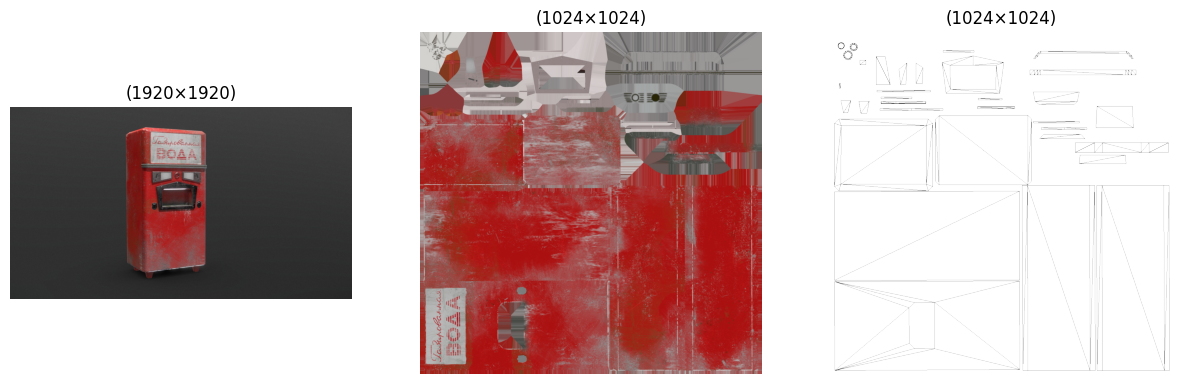

UV density = 3.06% --> OK


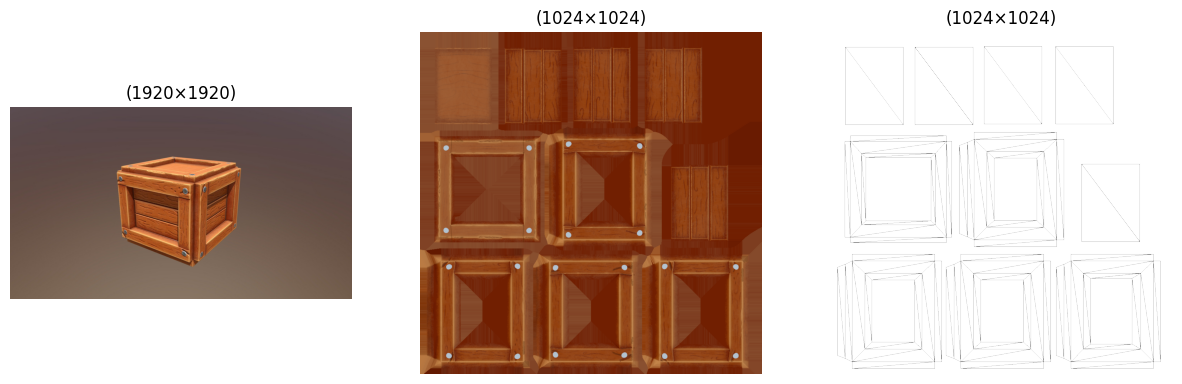

UV density = 3.94% --> OK


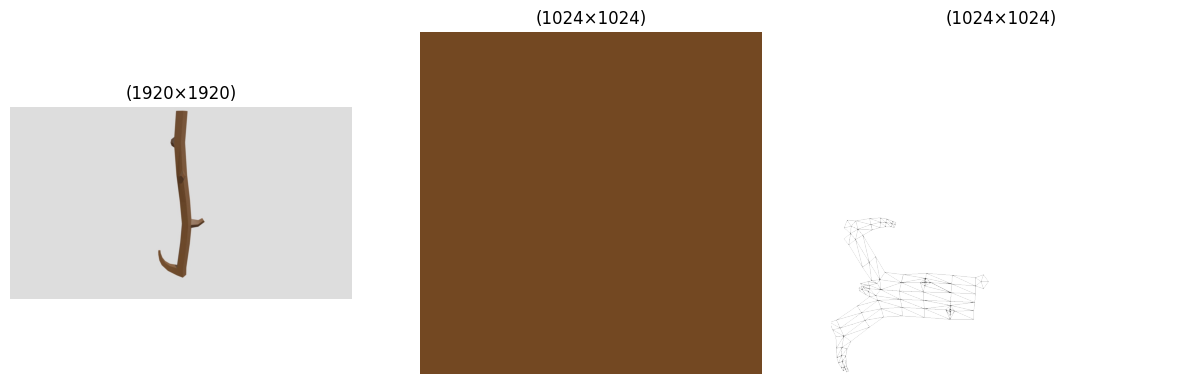

UV density = 0.82% --> TOO LOW


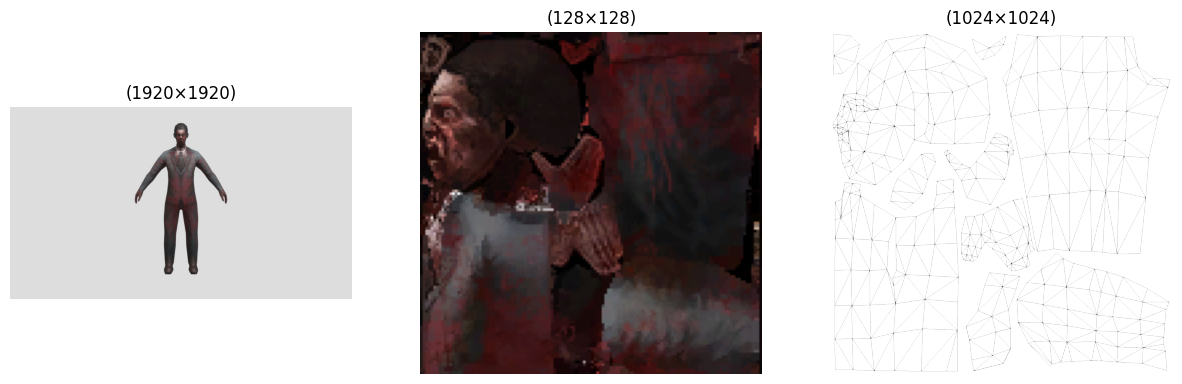

UV density = 4.45% --> OK


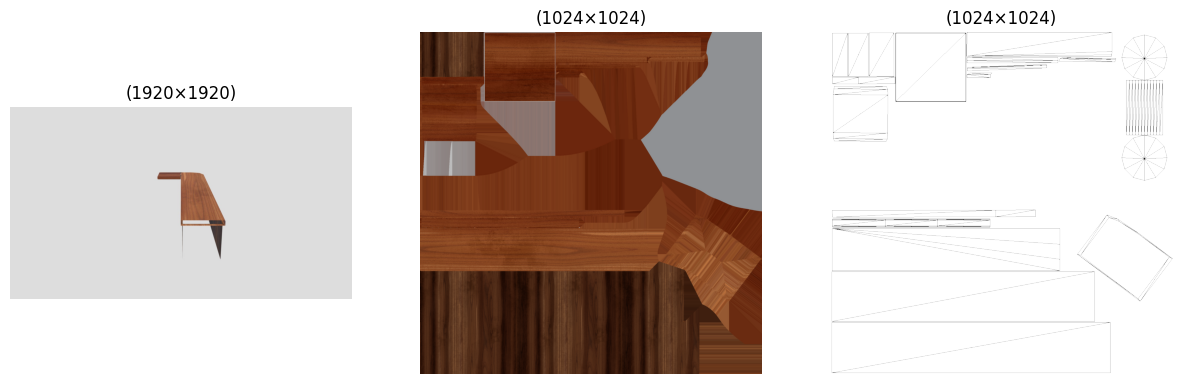

UV density = 3.32% --> OK


In [ ]:
MIN_UV_DENSITY = 0.01
SAMPLES = 5

for uid in uids[random.sample(range(len(uids)), SAMPLES)]:
    # Get the thumbnail
    thumbnail = requests.get(annotations.loc[uid]["thumbnail"]).content
    render = PILImage.open(BytesIO(thumbnail))

    # Extract diffuse texture
    mesh = next(x for x in load_model(gbls[uid]) if x.type == "MESH")
    diffuse = get_diffuse_textures(mesh)[0]

    diffuse.save(f"../data/dataset/diffuse/{uid}.png")

    # Bake UV map
    uv_map = draw_uv_map(mesh, size=1024, stroke=1)

    plot_images([render, diffuse, uv_map], cols=3, size=5)
    uv_density = compute_opacity(uv_map)
    print(
        colored(
            f"UV density = {uv_density:.2%} --> {'OK' if uv_density > MIN_UV_DENSITY else 'TOO LOW'}",
            "green" if uv_density > MIN_UV_DENSITY else "red",
        )
    )